<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2022DataProjectA/blob/main/Create_Data_Warehouse_and_Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importieren der von uns benötigten Funktionen

In [1]:
import sqlite3
import pandas as pd
import logging
import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Github Repo laden

In [2]:
# Load GitHub repo
%cd /content/
%rm -r ./DMA2022DataProjectA
!git clone https://github.com/Fuenfgeld/DMA2022DataProjectA.git
%cd ./DMA2022DataProjectA/Code/

/content
rm: cannot remove './DMA2022DataProjectA': No such file or directory
Cloning into 'DMA2022DataProjectA'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 272 (delta 15), reused 23 (delta 5), pack-reused 233
Receiving objects: 100% (272/272), 19.69 MiB | 13.75 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/DMA2022DataProjectA/Code


Konfigurieren des Loggings

In [3]:
logging.basicConfig(filename="../Logs/log.txt", level=logging.DEBUG)


Erstellen einer Verbindung zur Datenbank

In [4]:
#connect to DB
conn = sqlite3.connect('../datawarehouse.db')
cursor = conn.cursor()
logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipynb opened a connection to the database")
print("Opened database successfully");

Opened database successfully


Mithilfe von Pandas CSV-Dateien einlesen

In [5]:
#load CSVs
careplans = pd.read_csv('../Daten/careplans.csv', sep=",")
conditions = pd.read_csv('../Daten/conditions.csv', sep=",")
immunizations = pd.read_csv('../Daten/immunizations.csv', sep=",")
medications = pd.read_csv('../Daten/medications.csv', sep=",")
observations = pd.read_csv('../Daten/observations.csv', sep=",")
patients = pd.read_csv('../Daten/patients.csv', sep=",")

## Datenverschleierung

Für die Verschleierung der Daten wird aus den Werten mit, denen es möglich ist eine Person zu identifizieren ein Hash gebildet.

In [6]:
to_anonymize =  ("SSN","DRIVERS","PASSPORT","FIRST", "LAST","MAIDEN", "ADDRESS", "LAT", "LON", "BIRTHPLACE")
for idx in to_anonymize: 
    patients[idx] = patients[idx].apply(lambda x: hash(x) if(pd.isna(x) == False) else x)

Vorhandene Tabellen löschen, um Konflikte zu vermeiden

In [7]:
#Delete Tables in case they exist
cursor.execute("DROP TABLE IF EXISTS careplans")
cursor.execute("DROP TABLE IF EXISTS conditions")
cursor.execute("DROP TABLE IF EXISTS disease")
cursor.execute("DROP TABLE IF EXISTS immunizations")
cursor.execute("DROP TABLE IF EXISTS medications")
cursor.execute("DROP TABLE IF EXISTS observations")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS facts_table")
logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipyn dropped existing tables in the database")


Erstellen der Tabellen

In [8]:
#Create Tables
cursor.execute('''CREATE TABLE IF NOT EXISTS careplans (
                           Id STRING PRIMARY KEY,
                           START DATE,
                           STOP DATE,
                           PATIENT STRING,
                           ENCOUNTER STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           REASONCODE STRING,
                           REASONDESCRIPTION STRING,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 
                       )
                       ''')


cursor.execute('''CREATE TABLE IF NOT EXISTS conditions (
                           condition_code INTEGER PRIMARY KEY AUTOINCREMENT,
                           START DATE,
                           STOP DATE,
                           PATIENT STRING,
                           ENCOUNTER STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 
                        )
                       ''')



cursor.execute('''CREATE TABLE IF NOT EXISTS observations (
                           observation_code INTEGER PRIMARY KEY AUTOINCREMENT,
                           DATE DATE,
                           PATIENT STRING,
                           ENCOUNTER STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           VALUE STRING,
                           UNITS STRING,
                           TYPE STRING,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       )
                       ''')



cursor.execute('''CREATE TABLE IF NOT EXISTS patients (
                           Id STRING PRIMARY KEY,
                           BIRTHDATE DATE,
                           DEATHDATE DATE,
                           SSN STRING,
                           DRIVERS STRING,
                           PASSPORT STRING,
                           PREFIX STRING,
                           FIRST STRING,
                           LAST STRING,
                           SUFFIX STRING,
                           MAIDEN STRING,
                           MARITAL STRING,
                           RACE STRING,
                           ETHNICITY STRING,
                           GENDER STRING,
                           BIRTHPLACE STRING,
                           ADDRESS STRING,
                           CITY STRING,
                           STATE STRING,
                           COUNTY STRING,
                           ZIP STRING,
                           LAT INTEGER,
                           LON INTEGER,
                           HEALTHCARE_EXPENSES INTEGER,
                           HEALTHCARE_COVERAGE INTEGER
                       )
                       ''')

cursor.execute('''CREATE TABLE IF NOT EXISTS immunizations(
                           immunization_code INTEGER PRIMARY KEY AUTOINCREMENT,
                           DATE DATE,
                           PATIENT STRING,
                           ENCOUNTER STRING,
                           CODE STRING,
                           DESCRIPTION STRING,
                           BASE_COST INTEGER,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       )
                       ''')




logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipyn created needed tables in the database")

Die Daten aus den Dataframes in die erstellten Tabellen schreiben

In [9]:
#Insert into table
careplans.to_sql('careplans', conn, if_exists='append', index=False)
conditions.to_sql('conditions', conn, if_exists='append', index=False)
immunizations.to_sql('immunizations', conn, if_exists='append', index=False)
medications.to_sql('medications', conn, if_exists='append', index=False)
observations.to_sql('observations', conn, if_exists='append', index=False)
patients.to_sql('patients', conn, if_exists='append', index=False)

logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipyn wrote data from csvs into the database")

# Sternschema

Der Grund für die Verwendung eines Sternschemas liegt darin, die Anzahl der Join-Bedingungnen für die Auswertung der einzelnen Tabellen zu reduzieren. bei dem Sternschema wird eine Zentrale Datenbank erzeugt, welche die relevanten Daten enthält. Um den Kern des Sternschemas werden weitere Dimensions Tabellen angeordnet. Wichtig dabei kann es zu duplizierungen der Daten in kommen. Das Sternschema erlaubt uns, uns die Tabellen passende für unsere Forschungsfrage zusammenzujoinen.

### Faktentabelle erstellen

Die Faktentabelle enthält die Primary Keys aus allen anderen Tabellen. Zusätzlich werden die Attribute VALUE, START_DATE und STOP_DATE hinzugefügt. VALUE enthält hierbei entweder den CODE oder den VALUE der Tabelle aus der die Daten stammen. Das Selbe gilt für START_DATE und STOP_DATE. Gibt es in der ursprünglichen Tabelle nur ein DATE und kein START_DATE und STOP_DATE wird das Datum als START_DATE übernommen und STOP_DATE bleibt dann leer.

In [10]:
cursor.execute('''CREATE TABLE IF NOT EXISTS facts_table (
                          patient_ID STRING,
                          careplan_ID INT,
                          condition_id INT,
                          immunization_code INT,
                          VALUE STRING,
                          START_DATE DATE,
                          STOP_DATE DATE,
                          observation_code INT, 
                          FOREIGN KEY (patient_ID)
                            REFERENCES patients (Id) 
                          FOREIGN KEY (careplan_ID)
                            REFERENCES careplans (Id) 
                          FOREIGN KEY (condition_id)
                            REFERENCES conditions (condition_code)
                          FOREIGN KEY (immunization_code)
                            REFERENCES immunizations (immunization_code) 
                          FOREIGN KEY (observation_code)
                            REFERENCES observations (observation_code)                             

                       )
                       ''')

logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipyn created the facts_table")

In [11]:
print(pd.read_sql_query("PRAGMA table_info('facts_table')", conn))

   cid               name    type  notnull dflt_value  pk
0    0         patient_ID  STRING        0       None   0
1    1        careplan_ID     INT        0       None   0
2    2       condition_id     INT        0       None   0
3    3  immunization_code     INT        0       None   0
4    4              VALUE  STRING        0       None   0
5    5         START_DATE    DATE        0       None   0
6    6          STOP_DATE    DATE        0       None   0
7    7   observation_code     INT        0       None   0


### Daten in Faktentabelle übertragen

In [12]:
cursor.execute('''INSERT INTO facts_table        
                    (patient_ID, careplan_ID, VALUE, START_DATE, STOP_DATE) 
                    SELECT PATIENT, Id, CODE, START, STOP
                    FROM careplans
                    ;''')



cursor.execute('''INSERT INTO facts_table        
                    (patient_ID, observation_code, VALUE, START_DATE) 
                    SELECT PATIENT, CODE, VALUE, DATE 
                    FROM OBSERVATIONS
                    ;''')


cursor.execute('''INSERT INTO facts_table        
                    (patient_ID, condition_Id, VALUE, START_DATE, STOP_DATE) 
                    SELECT PATIENT, condition_code, CODE, START, STOP
                    FROM conditions
                    ;''')

cursor.execute('''INSERT INTO facts_table        
                    (patient_ID, immunization_code, VALUE, START_DATE) 
                    SELECT PATIENT, immunization_code, CODE, DATE
                    FROM immunizations
                    ;''')

logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipyn wrote data into the facts_table")

Nach dem Bearbeiten müssen wir unsere Anpassungen commiten und die Verbindung zur Datenbank beenden

In [13]:
conn.commit()
logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipynb commited changes to the database")
conn.close()
logging.debug(" "+str(datetime.datetime.now()) + " create_data_warehouse.ipynb closed the connection to the database")

In [14]:
print("Datawarehouse created successfully")
logging.debug(" "+str(datetime.datetime.now()) + " Datewarehouse was created")

Datawarehouse created successfully


# Analyse

Um unsere Forschungsfrage durchzuführen wird in diesem Notebook die Analyse durchgeführt. Weitere Informationen über die Forschungsfrage und unsere Dokumentation ist in unserem [Wiki](https://github.com/Fuenfgeld/DMA2022DataProjectA/wiki) zu finden.

In [15]:
#connect to DB
conn = sqlite3.connect('../datawarehouse.db')
cursor = conn.cursor()
logging.debug(" "+str(datetime.datetime.now()) + " analyse.ipynb opened a connection to the database")
print("Opened database successfully");

Opened database successfully


#### Zusätzliche Leiden der an Corona erkranten Patienten

In [16]:
df_infizierte_patienten_infos = pd.read_sql_query("SELECT patient_ID, facts_table.VALUE, conditions.DESCRIPTION AS Condition_Description, immunizations.CODE, observations.DESCRIPTION AS Observation_Description FROM facts_table LEFT JOIN conditions ON facts_table.patient_ID = conditions.PATIENT LEFT JOIN immunizations ON facts_table.patient_ID = immunizations.PATIENT LEFT JOIN observations ON facts_table.patient_ID = observations.PATIENT WHERE facts_table.condition_Id is NOT NULL AND (facts_table.VALUE==840539006 OR facts_table.VALUE==840544004)", conn)
df_infizierte_patienten_infos

,patient_ID,VALUE,Condition_Description,CODE,Observation_Description
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,COVID-19,83.0,Adenovirus A+B+C+D+E DNA [Presence] in Respira...
1,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,COVID-19,83.0,Body Height
2,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,COVID-19,83.0,Body Height
3,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,COVID-19,83.0,Body Mass Index
4,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,COVID-19,83.0,Body Weight
...,...,...,...,...,...
11736905,2712205f-755e-4897-acb3-926895b7d635,840539006,Joint pain (finding),140.0,None
11736906,2712205f-755e-4897-acb3-926895b7d635,840539006,Metabolic syndrome X (disorder),140.0,None
11736907,2712205f-755e-4897-acb3-926895b7d635,840539006,Muscle pain (finding),140.0,None
11736908,2712205f-755e-4897-acb3-926895b7d635,840539006,Sputum finding (finding),140.0,None


In [17]:
df_weitere_corona_beschwerden = df_infizierte_patienten_infos.groupby(by="Condition_Description", dropna=True)["Condition_Description"].count().to_frame()
df_weitere_corona_beschwerden.insert(loc=0, column='Description', value=df_weitere_corona_beschwerden.index)
df_weitere_corona_beschwerden = df_weitere_corona_beschwerden.rename(columns={"Condition_Description":"Count"})
df_weitere_corona_beschwerden = df_weitere_corona_beschwerden.sort_values(by=['Count'], ascending=False).reset_index(drop= True)
df_weitere_corona_beschwerden[2:12]

,Description,Count
2,Fever (finding),753414
3,Respiratory distress (finding),608742
4,Hypoxemia (disorder),608742
5,Pneumonia (disorder),608742
6,Cough (finding),568108
7,Loss of taste (finding),431277
8,Body mass index 30+ - obesity (finding),324275
9,Fatigue (finding),305015
10,Prediabetes,281945
11,Anemia (disorder),268734


[]

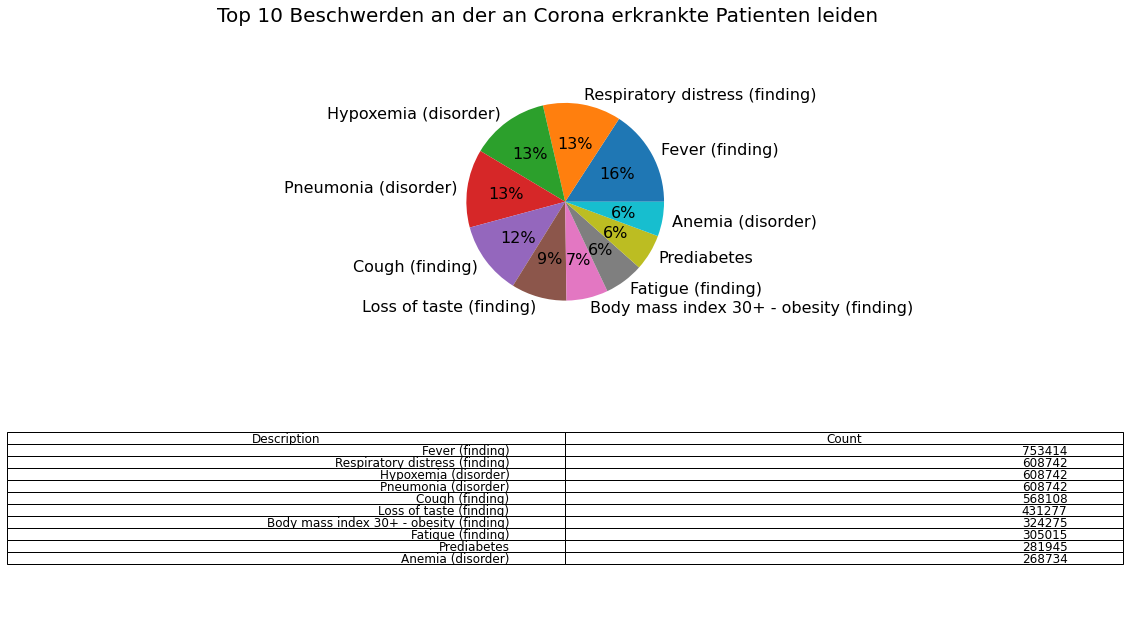

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1)
plt.gcf().set_size_inches(20, 10)

#Plot für Kuchendiagramm

pie = ax[0].pie(df_weitere_corona_beschwerden[2:12].Count,labels=df_weitere_corona_beschwerden.Description[2:12], autopct = '%0.0f%%', textprops={'fontsize': 16})


#Plot für Tabelle
table = ax[1].table(cellText=df_weitere_corona_beschwerden[2:12].values, colLabels=df_weitere_corona_beschwerden[2:12].columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
# ax[1].axis('tight')
ax[1].axis('off')


fig.suptitle("Top 10 Beschwerden an der an Corona erkrankte Patienten leiden",fontsize=20)
plt.plot()

Die folgende Query liefert und alle Patienten, die gegen Influenza geimpft wurden. Die Impfung mit dem Code 140 ist die Influenzaimpfung in unserem Datensatz

In [19]:
print(pd.read_sql_query("SELECT DISTINCT patient_ID, VALUE FROM facts_table WHERE immunization_code is NOT NULL AND VALUE==140", conn))

                                 patient_ID  VALUE
0      f0f3bc8d-ef38-49ce-a2bd-dfdda982b271    140
1      067318a4-db8f-447f-8b6e-f2f61e9baaa5    140
2      ae9efba3-ddc4-43f9-a781-f72019388548    140
3      199c586f-af16-4091-9998-ee4cfc02ee7a    140
4      f58bf921-cba1-475a-b4f8-dc6fa3b8f89c    140
...                                     ...    ...
10252  eec72396-d10e-4b8e-8fb6-25fc1e396031    140
10253  3daf2b90-c439-469f-bb44-fb6109c6a8a7    140
10254  cb03d88e-7f08-46a1-be78-70d9fe8262a7    140
10255  435be43f-cb57-442f-aeb2-51018b030ed0    140
10256  2712205f-755e-4897-acb3-926895b7d635    140

[10257 rows x 2 columns]


Die folgende Query liefert und alle Patienten, die gegen Influenza geimpft wurden. Jeder Patient der als VALUE "COVID-19" hat, ist an Covid-19 gestorben. Nach unserer Definition gilt ein Verlauf als schwer, wenn der Patient stirbt.

In [20]:
print(pd.read_sql_query("SELECT DISTINCT patient_ID, VALUE FROM facts_table WHERE observation_code is NOT NULL AND VALUE=='COVID-19'", conn))

                              patient_ID     VALUE
0   c70992c9-ff13-467b-9032-1901506edeef  COVID-19
1   a5c39700-6bf3-4984-af46-31344695e21b  COVID-19
2   edad31f3-5a08-4678-8d31-271a41a2aad5  COVID-19
3   000e7adf-cbaa-4fad-ab2f-658c32f7d4d3  COVID-19
4   ce718268-3e91-4d5d-98d0-508286f0eeb2  COVID-19
5   34916863-676d-4224-9356-c28e78526641  COVID-19
6   c16e1174-233b-4efd-8f47-aa12b35aef8a  COVID-19
7   dd5a1f10-b8e6-4141-8e0a-26f34f4ce412  COVID-19
8   6ef1728a-28e0-4dbd-989f-d91ebeffbac4  COVID-19
9   1505bc4d-8843-425b-aaa3-0e431d9402fd  COVID-19
10  0100f99a-1b5d-4a5b-a73f-559a920412e5  COVID-19
11  d4b977ce-8d36-4651-a593-4e403b78947f  COVID-19
12  7a51f54b-bf90-4319-a53f-76646e791e55  COVID-19
13  78d06517-d48c-49ef-ada2-8b5290b113dc  COVID-19
14  0008a63c-c95c-46c2-9ef3-831d68892019  COVID-19
15  991959ab-0188-4916-aa95-664845579bb0  COVID-19
16  51d02f7d-6a65-4d6c-aa5f-ef43f1e372cb  COVID-19
17  05fdcc72-b031-4947-a364-b29027807d53  COVID-19
18  9cd159bb-f711-45b3-a353-1e3

### Wie viele Patienten sind insgesamt gegen Influenza geimpft?

Mit der folgenden Query werden alle Patienten die in der Impftabelle vorhanden sind ausgegeben

In [21]:
df_alle_impfungen = pd.read_sql_query("SELECT DISTINCT patient_ID, VALUE FROM facts_table WHERE immunization_code is NOT NULL", conn)

Hier werden die Patienten kategorisiert. Die Kategorien sind "Hat eine Influenza Impfung erhalten" und "Hat keine Influenza Impfung erhalten"

In [22]:
geimpfte = []
geimpfte_patienten_all_df = pd.DataFrame(columns=['Patienten', 'Grippe Impfung'])
geimpfte_patienten_all_df.Patienten = df_alle_impfungen.patient_ID.unique()

#Prüfung ob der Code 140 in den Daten enthalten ist, dieser gibt Aufschluss darauf ob die Patienten eine Grippeimpfung erhalten haben. 
for id in df_alle_impfungen.patient_ID.unique():
    patient = df_alle_impfungen.loc[df_alle_impfungen.patient_ID == id]
    exist = 140 in patient['VALUE'].unique()
    geimpfte .append(exist)
geimpfte_patienten_all_df['Grippe Impfung']= geimpfte 
geimpfte_patienten_all_df

,Patienten,Grippe Impfung
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,True
1,067318a4-db8f-447f-8b6e-f2f61e9baaa5,True
2,ae9efba3-ddc4-43f9-a781-f72019388548,True
3,199c586f-af16-4091-9998-ee4cfc02ee7a,True
4,f58bf921-cba1-475a-b4f8-dc6fa3b8f89c,True
...,...,...
10371,eec72396-d10e-4b8e-8fb6-25fc1e396031,True
10372,3daf2b90-c439-469f-bb44-fb6109c6a8a7,True
10373,cb03d88e-7f08-46a1-be78-70d9fe8262a7,True
10374,435be43f-cb57-442f-aeb2-51018b030ed0,True


In [23]:
print("Es wurden", geimpfte_patienten_all_df['Grippe Impfung'].value_counts()[True], "Patienten gegen Influenza geimpft")
print(geimpfte_patienten_all_df['Grippe Impfung'].value_counts()[False], "Patienten wurden nicht gegen Influenza geimpft")


Es wurden 10257 Patienten gegen Influenza geimpft
119 Patienten wurden nicht gegen Influenza geimpft


In [24]:
verhaeltnis_geimpft_insgesamt = geimpfte_patienten_all_df['Grippe Impfung'].value_counts()[True] / len(geimpfte_patienten_all_df.index)
verhaeltnis_geimpft_insgesamt

0.9885312259059368

In [25]:
verhaeltnis_ungeimpft_insgesamt = geimpfte_patienten_all_df['Grippe Impfung'].value_counts()[False] / len(geimpfte_patienten_all_df.index)
verhaeltnis_ungeimpft_insgesamt

0.011468774094063224

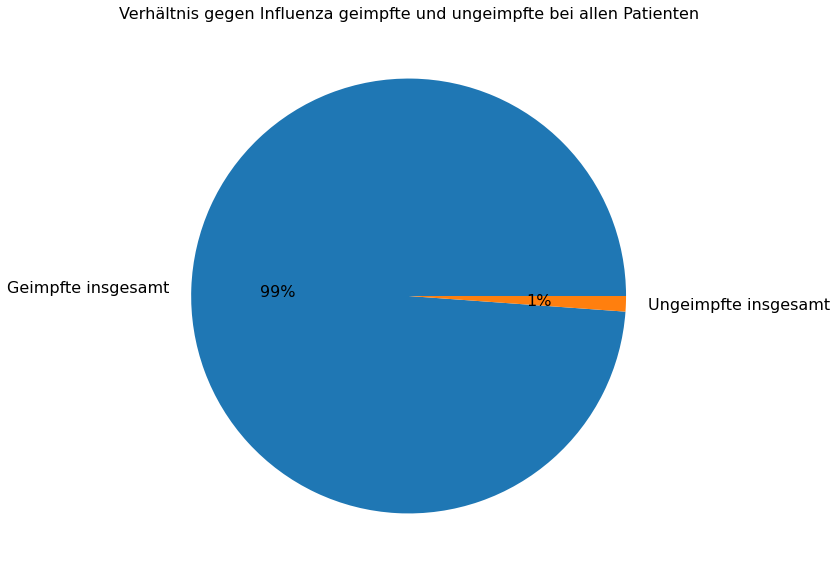

In [26]:
plt.gcf().set_size_inches(20, 10)
data = [verhaeltnis_geimpft_insgesamt, verhaeltnis_ungeimpft_insgesamt]
labels = ['Geimpfte insgesamt', 'Ungeimpfte insgesamt']
plt.title("Verhältnis gegen Influenza geimpfte und ungeimpfte bei allen Patienten", fontsize=16)
plt.pie(data, labels=labels, autopct = '%0.0f%%', textprops={'fontsize': 16})
plt.show()

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 7 Text major ticklabel objects>)

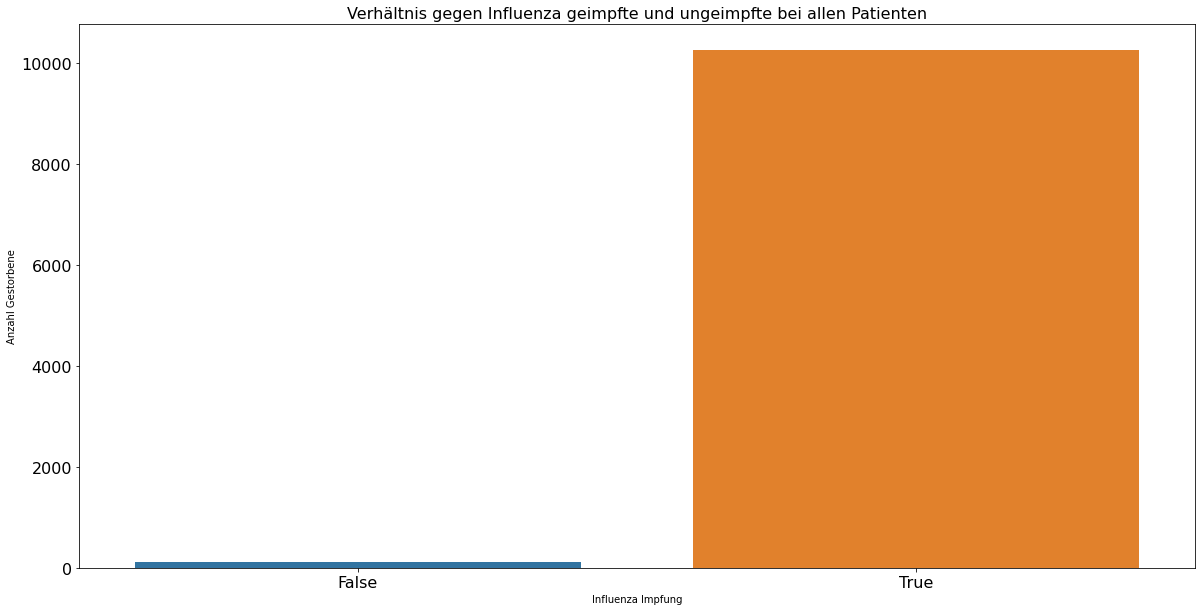

In [27]:
plt.gcf().set_size_inches(20, 10)
countplot_gestorbene = sns.countplot(x="Grippe Impfung", data=geimpfte_patienten_all_df)
plt.title("Verhältnis gegen Influenza geimpfte und ungeimpfte bei allen Patienten", fontsize=16)
countplot_gestorbene.set_ylabel("Anzahl Gestorbene")
countplot_gestorbene.set_xlabel("Influenza Impfung")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Es wird deutlich, dass es mehr Patienten gibt, die eine Influenza Impfung erhalten haben, als Patienten die keine Influenza Impfung erhalten haben. 

### Wie viele gestorbene waren gegen Influenza geimpft?

VALUE=840539006 und VALUE=840544004 bedeuten Suspected COVID-19 und COVID-19

In [28]:
df_gestorbene_patienten_infos = pd.read_sql_query("SELECT patient_ID, facts_table.VALUE, conditions.DESCRIPTION AS Condition_Description, immunizations.CODE, observations.DESCRIPTION AS Observation_Description FROM facts_table LEFT JOIN conditions ON facts_table.patient_ID = conditions.PATIENT LEFT JOIN immunizations ON facts_table.patient_ID = immunizations.PATIENT LEFT JOIN observations ON facts_table.patient_ID = observations.PATIENT WHERE facts_table.condition_Id is NOT NULL AND (facts_table.VALUE==840539006 OR facts_table.VALUE==840544004) AND observations.VALUE=='COVID-19'", conn)

#### Aufbau des Dataframes

In [29]:
df_gestorbene_patienten_infos.tail()

,patient_ID,VALUE,Condition_Description,CODE,Observation_Description
2257,26151e55-00b0-412b-8969-ed919ccce8cf,840539006,Pneumonia (disorder),140.0,Cause of Death [US Standard Certificate of Death]
2258,26151e55-00b0-412b-8969-ed919ccce8cf,840539006,Respiratory distress (finding),140.0,Cause of Death [US Standard Certificate of Death]
2259,26151e55-00b0-412b-8969-ed919ccce8cf,840539006,Sepsis caused by virus (disorder),140.0,Cause of Death [US Standard Certificate of Death]
2260,26151e55-00b0-412b-8969-ed919ccce8cf,840539006,Suspected COVID-19,140.0,Cause of Death [US Standard Certificate of Death]
2261,26151e55-00b0-412b-8969-ed919ccce8cf,840539006,Wheezing (finding),140.0,Cause of Death [US Standard Certificate of Death]


In [30]:
impfkandidat = []
geimpfte_patienten_df = pd.DataFrame(columns=['Patienten', 'Grippe Impfung'])
geimpfte_patienten_df.Patienten = df_gestorbene_patienten_infos.patient_ID.unique()

#Prüfung ob der Code 140 in den Daten enthalten ist, dieser gibt Aufschluss darauf ob die Patienten eine Grippeimpfung erhalten haben. 
for id in df_gestorbene_patienten_infos.patient_ID.unique():
    patient = df_gestorbene_patienten_infos.loc[df_gestorbene_patienten_infos.patient_ID == id]
    exist = 140 in patient['CODE'].unique()
    impfkandidat.append(exist)
geimpfte_patienten_df['Grippe Impfung']= impfkandidat

In [31]:
verhaeltnis_geimpft_tote = geimpfte_patienten_df['Grippe Impfung'].value_counts()[True] / len(geimpfte_patienten_df.index)
verhaeltnis_geimpft_tote

0.8125

81,25% aller gestorbenen waren gegen Influenza geimpft

In [32]:
verhaeltnis_ungeimpft_tote = geimpfte_patienten_df['Grippe Impfung'].value_counts()[False] / len(geimpfte_patienten_df.index)
verhaeltnis_ungeimpft_tote

0.1875

18,75% aller gestorbenen waren nicht gegen Influenza geimpft

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 10 Text major ticklabel objects>)

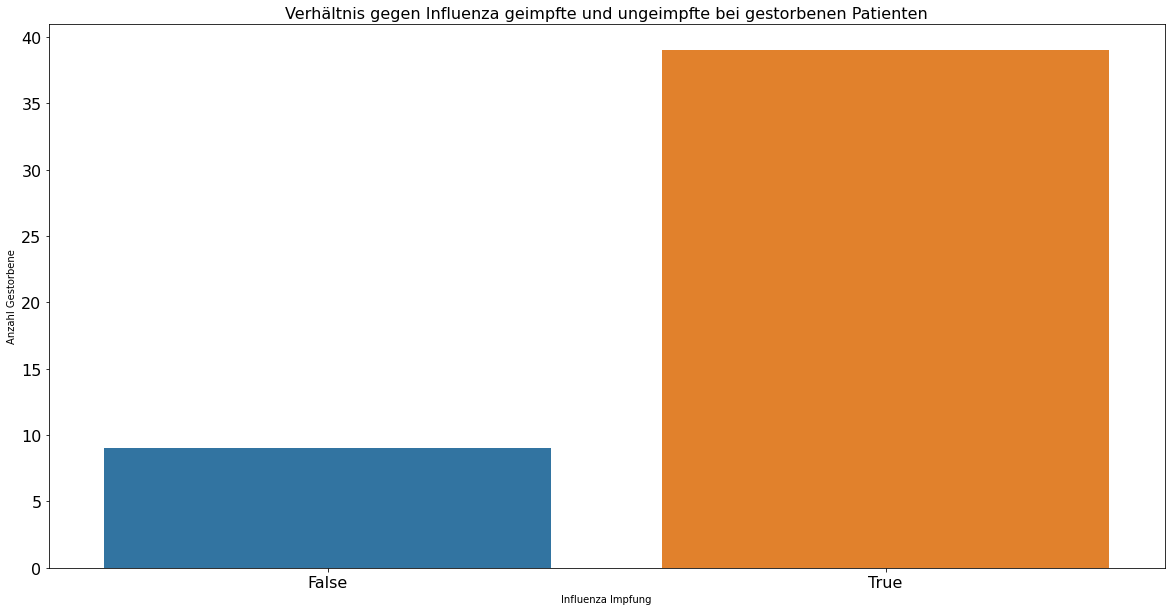

In [33]:
plt.gcf().set_size_inches(20, 10)
countplot_gestorbene = sns.countplot(x="Grippe Impfung", data=geimpfte_patienten_df)
plt.title("Verhältnis gegen Influenza geimpfte und ungeimpfte bei gestorbenen Patienten", fontsize=16)
countplot_gestorbene.set_ylabel("Anzahl Gestorbene")
countplot_gestorbene.set_xlabel("Influenza Impfung")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

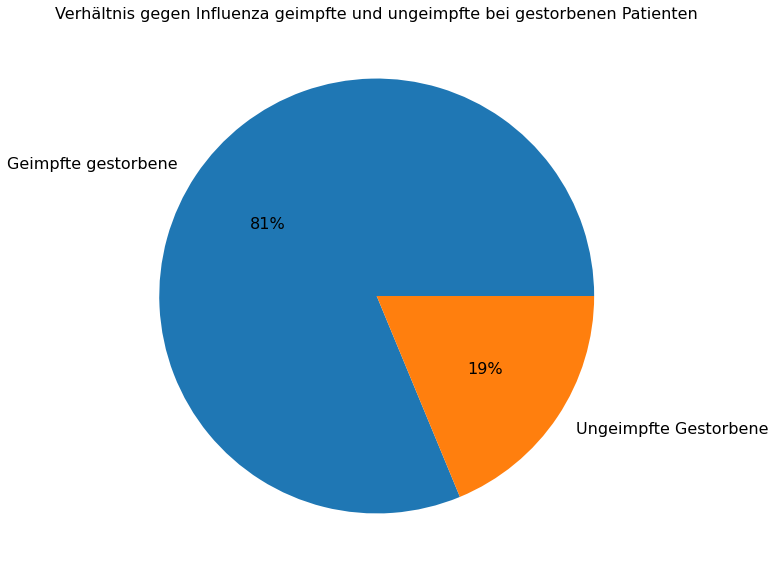

In [34]:
plt.gcf().set_size_inches(20, 10)
plt.title("Verhältnis gegen Influenza geimpfte und ungeimpfte bei gestorbenen Patienten", fontsize=16)
data = [verhaeltnis_geimpft_tote, verhaeltnis_ungeimpft_tote]
labels = ['Geimpfte gestorbene', 'Ungeimpfte Gestorbene']
plt.pie(data, labels=labels, autopct = '%0.0f%%', textprops={'fontsize': 16})

plt.show()

Generell sind im Datensatz deutlich mehr Influenzageimpfte Patienten (99%) als nicht gegen Influenza geimpfte Patienten (1%) vorhanden. Dieses Verhältnis hat sich bei den gestorbenen Patienten verändert, hier sind 19% der gestorbenen nicht gegen Influenza geimpft. Daraus könnte man schließen, dass die Sterbewahrscheinlichkeit für Covid-19 ohne Influenzaimpfung höher ist.
Nahliegender ist allerdings, dass Patienten, die sich gegen Influenza impfen lassen, auch offener gegenüber einer COVID-19 Impfung sind. Dies können wir aufgrund fehlender Daten leider nicht überprüfen.

## Hat die Ethnie einfluss auf die Sterbewahrscheinlichkeit bei Covid-19?

Für die Betrachung der Auswertung der Sterbewahrscheinlichkeit im Zusammenhang der Ethnie, können Sie über den [Link](https://github.com/Fuenfgeld/DMA2022DataProjectA/blob/main/Code/analyse.ipynb) auf das Jupyter Notebook für die Analyse zugreifen. Dies ist leider Notwenig, da die Menge an Daten den RAM der kostenlosen Version von Colab überstreitet. Alternativ können Sie sich auch die Grafiken im dem Repository zugreifen. [Verteilung der Ethnien bei allen Patienten](https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectA/main/Dokumentation/Bilder_analyse/verteilung_ethnien_alle.png),
[Verteilung der Ethnien bei den an COVID-19 gestrobenen](https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectA/main/Dokumentation/Bilder_analyse/verteilung_ethnien_gestorben.png)

[<img src=https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectA/main/Dokumentation/Bilder_analyse/verteilung_ethnien_alle.png width="1000"/>](https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectA/main/Dokumentation/Bilder_analyse/verteilung_ethnien_alle.png)

[<img src=https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectA/main/Dokumentation/Bilder_analyse/verteilung_ethnien_gestorben.png width="1000"/>](https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectA/main/Dokumentation/Bilder_analyse/verteilung_ethnien_gestorben.png)

In [ ]:
conn.close()
logging.debug(" "+str(datetime.datetime.now()) + " analyse.ipynb closed the connection to the database")